# Apresentação

O objetivo deste notebook é apresentar a solução para o trabalho individual proposto no módulo de **Análise Preditiva Avançada** do curso de MBA em Business Analytics e Big Data da FGV (turma Berrini).

**Professores**
* Gustavo Mirapalheta 
* Hitoshi Nagano

| Item                                                                                                                                                            | Dados do Aluno                                                          |
|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Nome                                                                                                                                                            | Leandro Daniel                                                          |
| Matrícula                                                                                                                                                       | A57622988                                                               |
| E-mail                                                                                                                                                          | <a href="mailto:contato@leandrodaniel.com">contato@leandrodaniel.com</a>|
| <a href="https://github.com/ldaniel"><img src="https://avatars2.githubusercontent.com/u/205534?s=460&v=4" title="ldaniel" width="50" height="50"></a>           | GitHub: https://github.com/ldaniel                                      |
| <a href="https://www.kaggle.com/leandrodaniel"><img src="https://avatars2.githubusercontent.com/u/205534?s=460&v=4" title="ldaniel" width="50" height="50"></a> | Kaggle: https://www.kaggle.com/leandrodaniel                            |

## Enunciado do Trabalho

### Questão 1
Tomando por base o conjunto de dados MNIST, padrão do pacote Keras, defina e elabore uma rede neural sequencial, apresentando os formatos dos tensores de entrada e saída, bem como os tensores intermediários na rede. Treine e teste o modelo de rede neural sequencial desenvolvido, de forma que ele consiga atingir uma precisão de pelo menos 97% no teste, no reconhecimento das imagens de números escritos à mão livre. Compare o desempenho da rede neural no treino utilizando dados normalizados e não normalizados.após 50 épocas de treino. Aumente o número de camadas internas da rede neural e determine se isto melhora ou não a qualidade dos resultados no teste. Qual o número de camadas que você consideraria ideal?

### Questão 2
Resolva o mesmo problema da Questão 1 utilizando o algoritmo Random Forests. Tentem trabalhar a hiperparametrização para aumento do desempenho. Compare o seu melhor resultado com o resultado obtido na Questão 1 e comente.

# Configuração inicial

## Instalando o TensorFlow

Criado pela equipe do Google Brain, o TensorFlow é uma biblioteca de código aberto para computação numérica e machine learning em larga escala. O TensorFlow reúne uma série de modelos e algoritmos de *machine learning* e *deep learning* (também conhecido como redes neurais) e os torna úteis por meio de uma metáfora comum. Ele usa o Python para fornecer uma API de front-end (o que aparece na tela) conveniente para criar aplicativos com a estrutura, enquanto executa esses aplicativos em C ++ de alto desempenho.

In [1]:
!pip install tensorflow-datasets

     |████████████████████████████████| 3.3 MB 2.7 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Definindo os pacotes requeridos

Abaixo temos todos os pacotes requeridos para executar este trabalho.

In [2]:
# basic libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# to perform Neural Networki analysis
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# to perform Random Forest analysis
from sklearn.ensemble import RandomForestClassifier

# to perform Hyperopt otimization
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

## Garantindo reprodutibilidade

Como o objetivo de garantir que os resultados sejam reproduzíveis a qualquer tempo, todos os seeds serão inicializados com o mesmo número.

In [3]:
# the answer to life the universe and everything
seed = 42

# defining the same seed for all ramdomic modules
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# MNIST Datasets

O banco de dados MNIST (do inglês, Modified National Institute of Standards and Technology database) é um grande banco de dados de dígitos manuscritos que é comumente usado para o treinamento de vários sistemas de processamento de imagens. Este banco de dados também é amplamente utilizado para treinamento e testes no campo da *machine learning*. Foi criado misturando as amostras dos conjuntos de dados originais do NIST.

Os criadores acharam que, como o conjunto de dados de treinamento do NIST foi obtido de funcionários do American Census Bureau, enquanto o conjunto de dados de teste foi coletado de estudantes americanos do ensino médio, não era adequado para experimentos de aprendizado de máquina. Além disso, as imagens em preto e branco do NIST foram normalizadas para caber em uma caixa delimitadora de 28x28 pixels e anti-alias, o que introduziu níveis de escala de cinza. 

O MNIST contém 60.000 imagens de treinamento e 10.000 imagens de teste. Metade do conjunto de treinamento e metade do conjunto de testes foram retirados do conjunto de dados de treinamento do NIST, enquanto a outra metade do conjunto de treinamento e a outra metade do conjunto de testes foram retirados do conjunto de dados de teste do NIST. 

In [4]:
# defining train dataset
x_train, y_train = tfds.as_numpy(
    tfds.load('mnist', 
              batch_size = -1,
              split = 'train',
              as_supervised = True))

# defining test dataset
x_test, y_test = tfds.as_numpy(
    tfds.load('mnist', 
              batch_size = -1,
              split = 'test',
              as_supervised = True))



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Checando o dataset do MNIST

Para averiguar se o dataset foi carregado, será utilizado o código abaixo para checar algumas imagens do dataset de treino.

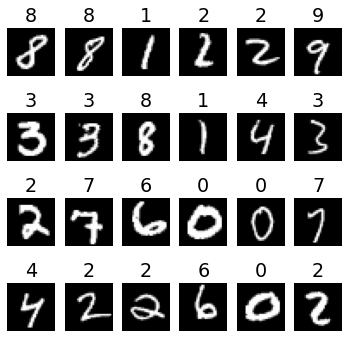

In [5]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize = (6, 6))
columns = 6
rows = 4

for i in range(1, columns * rows + 1):
    rnd = np.random.randint(0, len(x_train))
    img = np.reshape(x_train[rnd], (28, 28))
    fig.add_subplot(rows, columns, i)
    plt.title(y_train[rnd])
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')

plt.show()

## Definindo os datasets de treino e teste

Os datasets de treino e teste serão criados visando a transformação do shape dos tensores de labels **(60000,)** para **(60000, 1)**, bem como a transformação dos lables para dummies utilizando a função **to_categorical()** e, por fim, a normalização dos dados entre 0 e 1.

In [6]:
y_train = np.expand_dims(y_train, axis = 1)
y_test  = np.expand_dims(y_test, axis = 1)

y_train = to_categorical(y_train, num_classes = 10)
y_test  = to_categorical(y_test, num_classes = 10)

x_train = x_train / 255
x_test  = x_test / 255

# Redes Neurais

## Iniciando com uma rede neural simples

Como parte da **Questão 1**, será definida uma rede neural sequencial simples, com as seguintes características:

* **Hiden layers:**
    - **Total**: 1
    - **Neurons:** 512
    - **Activation function:** RELU
    - **Dropout:** 30%
* **Output layer:** 
    - **Neurons:** 10 neurons
    - **Activation function:** SOFTMAX

In [7]:
i = Input(x_train.shape[1:])

a = Flatten()(i)

a = Dense(512, activation = 'relu')(a)
a = Dropout(0.3)(a)

a = Dense(10, activation = 'softmax')(a)

model_NNS = Model(i ,a)

Na sequência, o tensor é compilado e configurado para o treino e seus resultados exibidos para conferência.

In [8]:
model_NNS.compile(optimizer = 'rmsprop',
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

model_NNS.summary(line_length = None, 
                  positions = None, 
                  print_fn = None)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Criando uma nova rede neural

Uma nova rede será criada com as seguintes características:

* **Hiden layers:**
    - **Total**: 3
    - **Neurons:** 512, 256, 128, 64
    - **Activation function:** RELU
    - **Dropout:** 30%, 20%, 20%, 20%
* **Output layer:** 
    - **Neurons:** 10 neurons
    - **Activation function:** SOFTMAX

In [9]:
i = Input(x_train.shape[1:])

b = Flatten()(i)

b = Dense(512, activation = 'relu')(b)
b = Dropout(0.3)(b)

b = Dense(256, activation = 'relu')(b)
b = Dropout(0.2)(b)

b = Dense(128, activation = 'relu')(b)
b = Dropout(0.2)(b)

b = Dense(64, activation = 'relu')(b)
b = Dropout(0.2)(b)

b = Dense(10, activation = 'softmax')(b)

model_NNC = Model(i ,b)

Novamente, o tensor é compilado e configurado para o treino e seus resultados exibidos para conferência.

In [10]:
model_NNC.compile(optimizer = 'rmsprop',
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

model_NNC.summary(line_length = None, 
                  positions = None, 
                  print_fn = None)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3289

## Criando uma nova rede neural convolucional (CNN)

Uma Rede Neural Convolucional (do inglês, Convolutional Neural Network ou **CNN**) é um algoritmo de Deep Learning que pode captar uma imagem de entrada, atribuir importância (pesos e vieses que podem ser aprendidos) a vários aspectos / objetos da imagem e ser capaz de diferenciar um do outro. O pré-processamento exigido em uma **CNN** é muito menor em comparação com outros algoritmos de classificação. Enquanto nos métodos primitivos os filtros são feitos à mão, com treinamento suficiente, as CNNs têm a capacidade de aprender esses filtros / características.

A arquitetura de uma **CNN** é análoga àquela do padrão de conectividade de neurônios no cérebro humano e foi inspirada na organização do Visual Cortex. Os neurônios individuais respondem a estímulos apenas em uma região restrita do campo visual conhecida como Campo Receptivo. Uma coleção desses campos se sobrepõe para cobrir toda a área visual.

Uma nova rede convolucional será criada com as características definidas, conforme código a seguir.

In [11]:
i = Input(x_train.shape[1:])

c = Conv2D(32, (3,3), activation ='relu', padding = 'same')(i)
c = BatchNormalization()(c)
c = Conv2D(32, (3,3), activation ='relu', padding = 'same')(c)
c = BatchNormalization()(c)
c = MaxPooling2D(2,2)(c)

c = Conv2D(64, (3,3), activation ='relu', padding = 'same')(c)
c = BatchNormalization()(c)
c = Conv2D(64, (3,3), activation ='relu', padding = 'same')(c)
c = BatchNormalization()(c)
c = MaxPooling2D(2,2)(c)

c = Conv2D(128, (3,3), activation ='relu', padding = 'same')(c)
c = BatchNormalization()(c)
c = Conv2D(128, (3,3), activation ='relu', padding = 'same')(c)
c = BatchNormalization()(c)
c = MaxPooling2D(2,2)(c)

c = Conv2D(256, (3,3), activation ='relu', padding = 'same')(c)
c = BatchNormalization()(c)
c = Conv2D(256, (3,3), activation ='relu', padding = 'same')(c)
c = BatchNormalization()(c)
c = MaxPooling2D(2,2)(c)

c = Flatten()(c)

c = Dense(512, activation = 'relu')(c)
c = Dropout(0.3)(c)

c = Dense(256, activation = 'relu')(c)
c = Dropout(0.2)(c)

c = Dense(128, activation = 'relu')(c)
c = Dropout(0.2)(c)

c = Dense(64, activation = 'relu')(c)
c = Dropout(0.2)(c)

c = Dense(10, activation = 'softmax')(c)

model_CNN = Model(i, c)

A rede convolucional será verificada, posteriormente, quanto a acurácia de classificação das imagens.

In [12]:
model_CNN.compile(optimizer = 'rmsprop',
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

model_CNN.summary(line_length = None, 
                  positions = None, 
                  print_fn = None)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1849

## Treinando os modelos de redes neurais

Os modelos serão treinados e testados de forma que ele consiga atingir, conforme solicitado pelo enunciado do trabalho:

`"(...) uma precisão de pelo menos 97% no teste, no reconhecimento das imagens de números escritos à mão livre (...)"`  

Na sequência, o modelo terá o desempenho comparado a rede neural no treino utilizando dados normalizados e não normalizados, após 50 épocas de treino.

In [13]:
batch_size = 2048

train_gen = ImageDataGenerator(rotation_range = 10,
                               horizontal_flip = False,
                               vertical_flip = False,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               rescale = 1.,
                               zoom_range = 0.2,
                               fill_mode = 'nearest',
                               cval = 0)

train_generator_NNS = train_gen.flow(x_train, y_train, batch_size)

# utilizado para o treinamento da rede sem a normalização dos dados
train_generator_NNS_N = train_gen.flow(x_train * 255, y_train, batch_size)

train_generator_NNC = train_gen.flow(x_train, y_train, batch_size)
train_generator_CNN = train_gen.flow(x_train, y_train, batch_size)

steps_per_epoch = x_train.shape[0] // batch_size

checkpoint_NNS = ModelCheckpoint('model_NNS.h5', 
                                 monitor = 'val_loss', 
                                 verbose = 0, 
                                 save_best_only = True, 
                                 mode = 'auto')

# checkpoint utilizado para o treinamento da rede sem a normalização dos dados
checkpoint_NNS_N = ModelCheckpoint('model_NNS_N.h5', 
                                   monitor = 'val_loss', 
                                   verbose = 0, 
                                   save_best_only = True, 
                                   mode = 'auto')

checkpoint_NNC = ModelCheckpoint('model_NNC.h5', 
                                 monitor = 'val_loss', 
                                 verbose = 0, 
                                 save_best_only = True, 
                                 mode = 'auto')

checkpoint_CNN = ModelCheckpoint('model_CNN.h5', 
                                 monitor = 'val_loss', 
                                 verbose = 0, 
                                 save_best_only = True, 
                                 mode = 'auto')

In [14]:
# setting the number of epochs
epochs = 50

In [15]:
%%time
history_NNS = model_NNS.fit(train_generator_NNS, 
                            validation_data = (x_test, y_test), 
                            steps_per_epoch = steps_per_epoch, 
                            epochs = epochs,
                            callbacks = [checkpoint_NNS])

Train for 29 steps, validate on 10000 samples
Epoch 1/50
29/29 [==============================] - 17s 595ms/step - loss: 1.3819 - accuracy: 0.5563 - val_loss: 0.6367 - val_accuracy: 0.8258
Epoch 2/50
29/29 [==============================] - 17s 582ms/step - loss: 0.8996 - accuracy: 0.7315 - val_loss: 0.4461 - val_accuracy: 0.8987
Epoch 3/50
29/29 [==============================] - 17s 585ms/step - loss: 0.6857 - accuracy: 0.8019 - val_loss: 0.3083 - val_accuracy: 0.9336
Epoch 4/50
29/29 [==============================] - 17s 591ms/step - loss: 0.5474 - accuracy: 0.8462 - val_loss: 0.2709 - val_accuracy: 0.9291
Epoch 5/50
29/29 [==============================] - 17s 584ms/step - loss: 0.4531 - accuracy: 0.8718 - val_loss: 0.2203 - val_accuracy: 0.9427
Epoch 6/50
29/29 [==============================] - 17s 588ms/step - loss: 0.3938 - accuracy: 0.8878 - val_loss: 0.1803 - val_accuracy: 0.9536
Epoch 7/50
29/29 [==============================] - 17s 592ms/step - loss: 0.3517 - accuracy: 0.

Seguindo a proposta da **Questão 1**, será realizada uma execução para avaliar o treino da rede com dados não normalizados.

In [16]:
%%time
history_NNS_N = model_NNS.fit(train_generator_NNS_N, 
                              validation_data = (x_test * 255, y_test), 
                              steps_per_epoch = steps_per_epoch, 
                              epochs = epochs,
                              callbacks = [checkpoint_NNS_N])

Train for 29 steps, validate on 10000 samples
Epoch 1/50
29/29 [==============================] - 16s 562ms/step - loss: 14.3350 - accuracy: 0.9627 - val_loss: 3.2515 - val_accuracy: 0.9853
Epoch 2/50
29/29 [==============================] - 17s 576ms/step - loss: 10.3046 - accuracy: 0.9618 - val_loss: 2.6958 - val_accuracy: 0.9841
Epoch 3/50
29/29 [==============================] - 17s 586ms/step - loss: 8.4551 - accuracy: 0.9597 - val_loss: 2.5009 - val_accuracy: 0.9823
Epoch 4/50
29/29 [==============================] - 17s 576ms/step - loss: 7.7189 - accuracy: 0.9573 - val_loss: 1.9715 - val_accuracy: 0.9824
Epoch 5/50
29/29 [==============================] - 17s 576ms/step - loss: 6.4726 - accuracy: 0.9536 - val_loss: 1.9706 - val_accuracy: 0.9801
Epoch 6/50
29/29 [==============================] - 17s 569ms/step - loss: 5.9565 - accuracy: 0.9487 - val_loss: 1.8164 - val_accuracy: 0.9780
Epoch 7/50
29/29 [==============================] - 17s 580ms/step - loss: 5.1207 - accuracy: 

Na sequência, será realizada uma execução para avaliar o treino da rede com mais camadas para determinarmos se isto melhora ou não a qualidade dos resultados no teste.

In [17]:
%%time
history_NNC = model_NNC.fit(train_generator_NNC, 
                            validation_data = (x_test, y_test), 
                            steps_per_epoch = steps_per_epoch, 
                            epochs = epochs,
                            callbacks = [checkpoint_NNC])

Train for 29 steps, validate on 10000 samples
Epoch 1/50
29/29 [==============================] - 18s 607ms/step - loss: 1.6925 - accuracy: 0.4209 - val_loss: 0.6020 - val_accuracy: 0.8529
Epoch 2/50
29/29 [==============================] - 18s 605ms/step - loss: 1.0261 - accuracy: 0.6652 - val_loss: 0.3847 - val_accuracy: 0.8813
Epoch 3/50
29/29 [==============================] - 18s 605ms/step - loss: 0.7430 - accuracy: 0.7584 - val_loss: 0.3124 - val_accuracy: 0.9034
Epoch 4/50
29/29 [==============================] - 17s 603ms/step - loss: 0.5672 - accuracy: 0.8205 - val_loss: 0.3035 - val_accuracy: 0.9036
Epoch 5/50
29/29 [==============================] - 17s 600ms/step - loss: 0.4770 - accuracy: 0.8522 - val_loss: 0.1877 - val_accuracy: 0.9413
Epoch 6/50
29/29 [==============================] - 17s 602ms/step - loss: 0.4150 - accuracy: 0.8740 - val_loss: 0.1527 - val_accuracy: 0.9501
Epoch 7/50
29/29 [==============================] - 17s 600ms/step - loss: 0.3558 - accuracy: 0.

Por fim, será realizada uma execução para avaliar o treino da rede neural convolucional.

In [18]:
%%time
history_CNN = model_CNN.fit(train_generator_CNN, 
                            validation_data = (x_test, y_test), 
                            steps_per_epoch = steps_per_epoch, 
                            epochs = epochs,
                            callbacks = [checkpoint_CNN])

Train for 29 steps, validate on 10000 samples
Epoch 1/50
29/29 [==============================] - 278s 10s/step - loss: 1.2582 - accuracy: 0.5698 - val_loss: 2.7834 - val_accuracy: 0.1135
Epoch 2/50
29/29 [==============================] - 274s 9s/step - loss: 0.2423 - accuracy: 0.9415 - val_loss: 3.6733 - val_accuracy: 0.1135
Epoch 3/50
29/29 [==============================] - 272s 9s/step - loss: 0.1451 - accuracy: 0.9654 - val_loss: 5.8366 - val_accuracy: 0.1135
Epoch 4/50
29/29 [==============================] - 272s 9s/step - loss: 0.1176 - accuracy: 0.9729 - val_loss: 5.4300 - val_accuracy: 0.1135
Epoch 5/50
29/29 [==============================] - 271s 9s/step - loss: 0.0755 - accuracy: 0.9812 - val_loss: 2.6585 - val_accuracy: 0.1366
Epoch 6/50
29/29 [==============================] - 271s 9s/step - loss: 0.0898 - accuracy: 0.9798 - val_loss: 2.4006 - val_accuracy: 0.2362
Epoch 7/50
29/29 [==============================] - 270s 9s/step - loss: 0.0591 - accuracy: 0.9856 - val_lo

In [19]:
model_NNS   = tf.keras.models.load_model('model_NNS.h5')
model_NNS_N = tf.keras.models.load_model('model_NNS_N.h5')
model_NNC   = tf.keras.models.load_model('model_NNC.h5')
model_CNN   = tf.keras.models.load_model('model_CNN.h5')

## Comparando o desempenho das 4 redes neurais

Dos 4 modelos desenvolvidos é possível verificar que o modelo convolucional (CNN) é o que apresenta maior acurácia e maior velocidade de convergência dos parâmetros. Os dados normalizados não apresentaram ganho ou perdas expressivsas ao modelo.

In [20]:
def pred(model, x_test):
    pred_prob = model.predict(x_test)
    pred = np.argmax(pred_prob, axis = 1)
    return pred

print('\033[1;36m[ Rede Neural Simples (Normalizada) -----------------------] \033[0;0m')
print(classification_report(np.argmax(y_test, axis = 1), pred(model_NNS, x_test)))
print("Accuracy: %.4f" % accuracy_score(np.argmax(y_test, axis = 1), pred(model_NNS, x_test)))
print('\n\r')

print('\033[1;36m[ Rede Neural Simples (Não Normalizada) -------------------] \033[0;0m')
print(classification_report(np.argmax(y_test, axis = 1), pred(model_NNS_N, x_test * 255)))
print("Accuracy: %.4f" % accuracy_score(np.argmax(y_test, axis = 1), pred(model_NNS_N, x_test * 255)))
print('\n\r')

print('\033[1;36m[ Rede Neural Complexa ------------------------------------] \033[0;0m')
print(classification_report(np.argmax(y_test, axis = 1), pred(model_NNC, x_test)))
print("Accuracy: %.4f" % accuracy_score(np.argmax(y_test, axis = 1), pred(model_NNC, x_test)))
print('\n\r')

print('\033[1;36m[ Rede Neural Convolucional (CNN) -------------------------] \033[0;0m')
print(classification_report(np.argmax(y_test, axis = 1), pred(model_CNN, x_test)))
print("Accuracy: %.4f" % accuracy_score(np.argmax(y_test, axis = 1), pred(model_CNN, x_test)))
print('\n\r')

[ Rede Neural Simples (Normalizada) -----------------------] 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Accuracy: 0.9852


[ Rede Neural Simples (Não Normalizada) -------------------] 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98

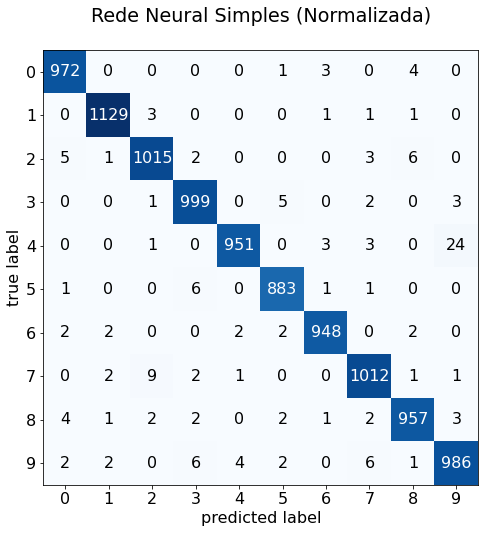

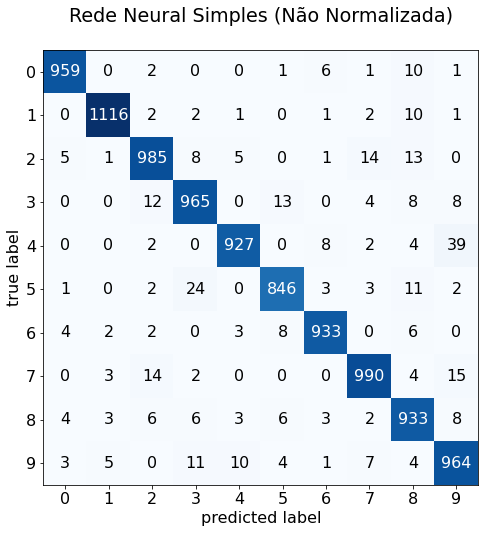

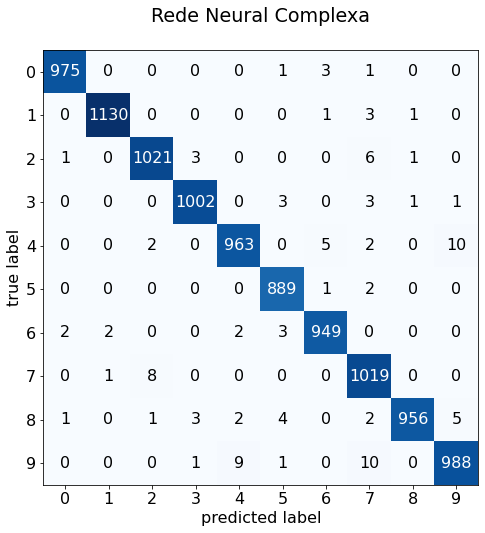

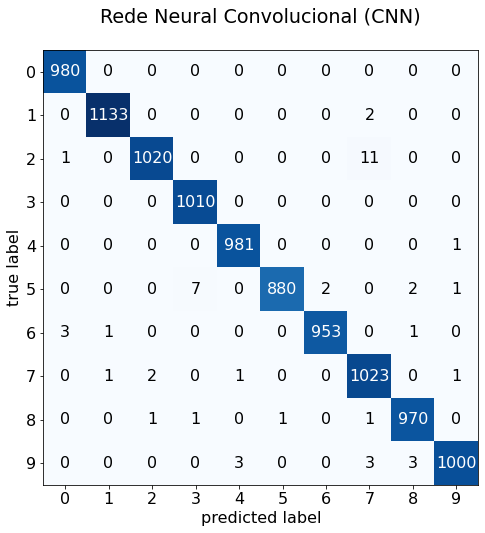

In [21]:
plt.rcParams.update({'font.size': 16})

def plot_confusion_mtx(model, x_test, plot_tittle):
    pred_prob = model.predict(x_test)
    pred = np.argmax(pred_prob, axis = 1)

    CM = confusion_matrix(np.argmax(y_test, axis = 1), pred)

    plot_confusion_matrix(conf_mat = CM, figsize = (16, 8))
    plt.title(plot_tittle)
    plt.xticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    plt.show()

plot_confusion_mtx(model_NNS, x_test, 'Rede Neural Simples (Normalizada)')
plot_confusion_mtx(model_NNS_N, x_test * 255, 'Rede Neural Simples (Não Normalizada)')
plot_confusion_mtx(model_NNC, x_test, 'Rede Neural Complexa')
plot_confusion_mtx(model_CNN, x_test, 'Rede Neural Convolucional (CNN)')

In [22]:
y_true = np.argmax(y_test, axis = 1)
pred_prob = model_CNN.predict(x_test)
y_pred = np.argmax(pred_prob, axis = 1)
errors = (y_pred - y_true != 0)
hits = (y_pred - y_true == 0)

y_test_erros  = y_pred[errors]
y_true_errors = y_true[errors]
x_test_errors = x_test[errors]

y_test_hits  = y_pred[hits]
y_true_hits = y_true[hits]
x_test_hits = x_test[hits]

print('\033[1;32mPerformance do modelo escolhido \033[0;0m')
print('\033[0;36mRede Neural Convolucional (CNN) \033[0;0m')
print('\033[0;36mTotal de erros: \t' + str(len(y_test_erros)) + "\033[0;36m")
print('\033[0;36mTotal de acertos: \t' + str(len(y_test_hits)) + "\033[0;36m")

Performance do modelo escolhido 
Rede Neural Convolucional (CNN) 
Total de erros: 	50
Total de acertos: 	9950


Em se tratando de redes neurais não convolucionais, a aboardagem de utilização de uma única camada pode ser suficiente para resolver o problema com uma acurácia satisfatória e com um tempo de processamento não muito elevado. A adição de camadas convolucionais, tomando-se como exemplo os inúmeros testes realizados pela comunidade de cientistas de dados, mostra que  resultado das redes neurais melhorar de forma expressiva quando aplicadas a imagens.

# Random Forest

Os chamados **métodos ensemble**, são construídos da mesma forma que algoritmos mais básicos, como regressão linear, árvore de decisão ou knn, por exemplo, mas possuem uma característica principal que os diferenciam, a combinação de diferentes modelos para se obter um único resultado. Essa característica torna esses algoritmos mais robustos e complexos, levando a um maior custo computacional que costuma ser acompanhando de melhores resultados.

Normalmente na criação de um modelo, escolhemos o algoritmo que apresenta o melhor desempenho para os dados em questão. Podemos testar diferentes configurações deste algoritmo escolhido, gerando assim diferentes modelos, mas no fim do processo de machine learning, escolhemos apenas um. Com um método ensemble serão criados vários modelos diferentes a partir de um algoritmo, mas não escolheremos apenas um para utilização final, e sim todos. 

No algoritmo **Random Forest** serão criadas várias árvores de decisão,a “floresta” que ele cria é uma combinação (ensemble) de árvores de decisão, na maioria dos casos treinados com o método de bagging. A idéia principal do método de bagging é que a combinação dos modelos de aprendizado aumenta o resultado geral.

Uma grande vantagem do algoritmo de florestas aleatórias é que ele pode ser utilizado tanto para tarefas de classificação quanto para regressão, o que representa a maioria dos sistemas de aprendizagem de máquina atuais.

## Reiniciando os datasets de treino e test

Antes de iniciarmos a análise com o **Random Forest**, vamos reiniciar os datasets de treino e teste para sua condição inicial, a fim de termos os mesmos parâmetros de partida para analisarmos a performance, posteriormente. Também será realizados o *reshape* dos tensores para que cada pixel represente uma variável do modelo.

In [23]:
x_train, y_train = tfds.as_numpy(
    tfds.load('mnist', 
              batch_size = -1,
              split = 'train',
              as_supervised = True))

x_test, y_test = tfds.as_numpy(
    tfds.load('mnist', 
              batch_size = -1,
              split = 'test',
              as_supervised = True))

# reshaping tensors to represent the pixels
x_train = x_train.reshape([x_train.shape[0], -1]).astype('float32')
x_test  = x_test.reshape([x_test.shape[0], -1]).astype('float32')

x_train.shape

(60000, 784)

## Criando e executando o modelo Random Forest (não otimizado)

Conforme proposta da **Questão 2**, será criado um modelo de *Random Forest* utilizando alguns hiperparâmetros para uma análise inicial.

In [24]:
%%time
RF = RandomForestClassifier(n_estimators = 100,
                            criterion = 'gini',
                            max_depth = 256,
                            min_samples_split = 15,
                            min_samples_leaf = 10,
                            n_jobs = -1,
                            random_state = seed)

RF.fit(x_train, y_train)

CPU times: user 56 s, sys: 76 ms, total: 56.1 s
Wall time: 14.4 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=256, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

A acurácia do modelo é verificada a seguir.

In [25]:
pred = RF.predict(x_test)

print('\033[1;36m[ Random Forest (não otimizado) ---------------------------] \033[0;0m')
print(classification_report(y_test, pred))
print("Accuracy: %.4f" % accuracy_score(y_test, pred))
print('\n\r')

[ Random Forest (não otimizado) ---------------------------] 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.96      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.97      0.95      0.96       892
           6       0.96      0.97      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Accuracy: 0.9593




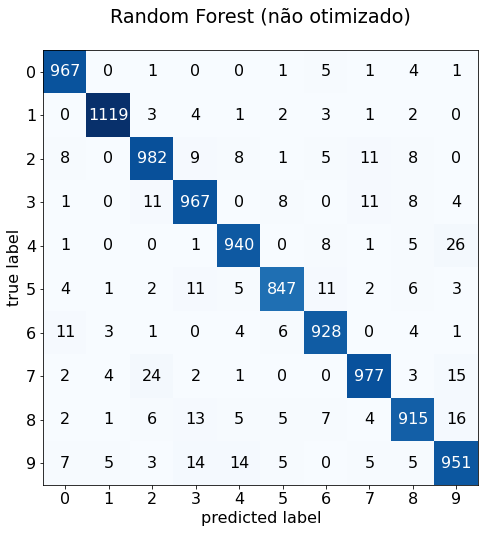

In [26]:
plt.rcParams.update({'font.size': 16})

def plot_confusion_mtx(model, x_test, plot_tittle):
    pred= model.predict(x_test)

    CM = confusion_matrix(y_test, pred)

    plot_confusion_matrix(conf_mat = CM, figsize = (16, 8))
    plt.title(plot_tittle)
    plt.xticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.yticks(range(10), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    plt.show()

plot_confusion_mtx(RF, x_test, 'Random Forest (não otimizado)')

In [27]:
y_pred = RF.predict(x_test)
errors = (y_pred - y_test != 0)
hits = (y_pred - y_test == 0)

y_test_erros  = y_pred[errors]
y_true_errors = y_test[errors]
x_test_errors = x_test[errors]

y_test_hits  = y_pred[hits]
y_true_hits = y_test[hits]
x_test_hits = x_test[hits]

print('\033[1;32mPerformance do modelo \033[0;0m')
print('\033[0;36mRandom Forest (não otimizado) \033[0;0m')
print('\033[0;36mTotal de erros: \t' + str(len(y_test_erros)) + "\033[0;36m")
print('\033[0;36mTotal de acertos: \t' + str(len(y_test_hits)) + "\033[0;36m")

Performance do modelo 
Random Forest (não otimizado) 
Total de erros: 	407
Total de acertos: 	9593


## Otimizando o modelo Random Forest com hiperparametrização

O Hyperopt é uma biblioteca Python para otimização serial e paralela em espaços de pesquisa "estranhos", que podem incluir dimensões com valor real, discretas e condicionais. O código a seguir inicializa um `space` de configuração de hiperparâmetros.

In [28]:
hyper_space = {'n_estimators': hp.quniform('n_estimators', 25, 500, 5),
               'criterion': hp.choice('criterion', ["gini", "entropy"]),
               'max_depth': hp.quniform('max_depth', 1, 100, 1),
               'min_samples_split': hp.quniform('min_samples_split', 5, 50, 1),
               'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 20, 1)}

Em seguida, será definido o  modelo em uma função que utiliza os valores presentes em nosso espaço de busca, configurado anteriormente.

In [29]:
def hyper_RF(hyper_space):
    
    global best_score
    
    RF = RandomForestClassifier(n_estimators = int(hyper_space['n_estimators']),
                                criterion = hyper_space['criterion'],
                                max_depth = int(hyper_space['max_depth']),
                                min_samples_split = int(hyper_space['min_samples_split']),
                                min_samples_leaf = int(hyper_space['min_samples_leaf']),
                                n_jobs = -1,
                                random_state = seed)

    RF.fit(x_train, y_train)

    pred = RF.predict(x_test)
    acc = 1 - accuracy_score(y_test, pred)
    
    if (acc < best_score):
        best_score = acc
    
    return {'loss': acc, 'status': STATUS_OK }

Na sequência, será iniciado o objeto `Trials` que irá armazenar o resultdado de cada uma das **50** interações do processo de otimização realizado pela função `fmin`.

In [30]:
%%time
trials = Trials()
neval = 50
best_score = 0

best_hyper = fmin(fn = hyper_RF,
                  space = hyper_space,
                  algo = tpe.suggest,
                  max_evals = neval,
                  trials = trials,
                  rstate = np.random.RandomState(seed))

best_hyper

100%|██████████| 50/50 [36:05<00:00, 43.31s/trial, best loss: 0.03090000000000004]
CPU times: user 2h 19min 41s, sys: 6.15 s, total: 2h 19min 47s
Wall time: 36min 5s


{'criterion': 1,
 'max_depth': 99.0,
 'min_samples_leaf': 2.0,
 'min_samples_split': 9.0,
 'n_estimators': 180.0}

Por fim, será realizado o treinamento de um modelo **Random Forest** com os melhores hiperparâmetros encontrados no espaço de busca executado anteriormente.

In [31]:
OPT_RF = RandomForestClassifier(n_estimators = int(best_hyper['n_estimators']),
                                criterion = ["gini", "entropy"][best_hyper['criterion']],
                                max_depth = int(best_hyper['max_depth']),
                                min_samples_split = int(best_hyper['min_samples_split']),
                                min_samples_leaf = int(best_hyper['min_samples_leaf']),
                                n_jobs = -1, 
                                random_state = seed)

OPT_RF.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=99, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

A acurácia do modelo de **Random Forest** com hiperparâmetros é verificada, de forma semelhante aos demais modelos.

In [32]:
pred = OPT_RF.predict(x_test)

print('\033[1;36m[ Random Forest (otimizado) -------------------------------] \033[0;0m')
print(classification_report(y_test, pred))
print("Accuracy: %.4f" % accuracy_score(y_test, pred))
print('\n\r')

[ Random Forest (otimizado) -------------------------------] 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy: 0.9691




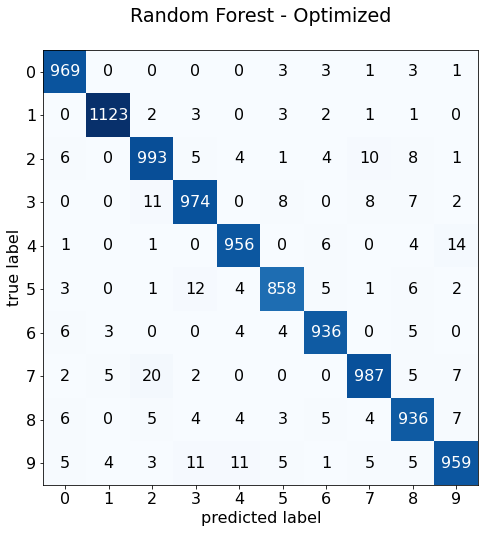

In [33]:
plot_confusion_mtx(OPT_RF, x_test, 'Random Forest - Optimized')

In [34]:
y_pred = OPT_RF.predict(x_test)
errors = (y_pred - y_test != 0)
hits = (y_pred - y_test == 0)

y_test_erros  = y_pred[errors]
y_true_errors = y_test[errors]
x_test_errors = x_test[errors]

y_test_hits  = y_pred[hits]
y_true_hits = y_test[hits]
x_test_hits = x_test[hits]

print('\033[1;32mPerformance do modelo \033[0;0m')
print('\033[0;36mRandom Forest (otimizado) \033[0;0m')
print('\033[0;36mTotal de erros: \t' + str(len(y_test_erros)) + "\033[0;36m")
print('\033[0;36mTotal de acertos: \t' + str(len(y_test_hits)) + "\033[0;36m")

Performance do modelo 
Random Forest (otimizado) 
Total de erros: 	309
Total de acertos: 	9691


Para a etapa do trabalho baseada em **Random Forest** foram utiliadas duas abordagens, sendo a primeira com um modelo não otimizado e a segunda utilizando hiperparâmetros. Em comparação com a etapa baseada em Redes Neurais, podemos concluir que a performance ficou aquém nos modelos baseados em **Random Forest**, ademais, o tempo de processamento e hardware necessários para executar este tipo de modelo é muito superior aos das Redes Neurais.

# Referências

* https://www.tensorflow.org/api_docs/python/tf/keras
* http://deeplearningbook.com.br/introducao-as-redes-neurais-convolucionais/
* https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/
* https://medium.com/machina-sapiens/o-algoritmo-da-floresta-aleat%C3%B3ria-3545f6babdf8